In [1]:
import os,sys
import pandas as pd
%matplotlib inline
os.chdir("jeme/JEME vs targetfinder/")
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals.joblib import Parallel, delayed

In [3]:
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score, roc_auc_score

In [4]:
from sklearn.ensemble import RandomForestClassifier
from itertools import combinations

In [9]:
import sklearn
sklearn.__version__

'0.18.1'

In [6]:
pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name']).head()

bin  \
enhancer_name                  promoter_name                         
K562|chr10:100140000-100141200 K562|chr10:100027507-100028507    4   
                               K562|chr10:99185417-99186417      5   
                               K562|chr10:99205274-99206274      5   
                               K562|chr10:99205427-99206427      5   
                               K562|chr10:99343631-99344631      5   

                                                              enhancer_chrom  \
enhancer_name                  promoter_name                                   
K562|chr10:100140000-100141200 K562|chr10:100027507-100028507          chr10   
                               K562|chr10:99185417-99186417            chr10   
                               K562|chr10:99205274-99206274            chr10   
                               K562|chr10:99205427-99206427            chr10   
                               K562|chr10:99343631-99344631            chr10   

                                                               enhancer_distance_to_promoter  \
enhancer_name                  promoter_name                                                   
K562|chr10:100140000-100141200 K562|chr10:100027507-100028507                         112593   
                               K562|chr10:99185417-99186417                           954683   
                               K562|chr10:99205274-99206274                           934826   
                               K562|chr10:99205427-99206427                           934673   
                               K562|chr10:99343631-99344631                           796469   

                                                               enhancer_end  \
enhancer_name                  promoter_name                                  
K562|chr10:100140000-100141200 K562|chr10:100027507-100028507     100141200   
                               K562|chr10:99185417-99186417       100141200   
                               K562|chr10:99205274-99206274       100141200   
                               K562|chr10:99205427-99206427       100141200   
                               K562|chr10:99343631-99344631       100141200   

                                                               enhancer_start  \
enhancer_name                  promoter_name                                    
K562|chr10:100140000-100141200 K562|chr10:100027507-100028507       100140000   
                               K562|chr10:99185417-99186417         100140000   
                               K562|chr10:99205274-99206274         100140000   
                               K562|chr10:99205427-99206427         100140000   
                               K562|chr10:99343631-99344631         100140000   

                                                               label  \
enhancer_name                  promoter_name                           
K562|chr10:100140000-100141200 K562|chr10:100027507-100028507      0   
                               K562|chr10:99185417-99186417        0   
                               K562|chr10:99205274-99206274        0   
                               K562|chr10:99205427-99206427        0   
                               K562|chr10:99343631-99344631        0   

                                                              promoter_chrom  \
enhancer_name                  promoter_name                                   
K562|chr10:100140000-100141200 K562|chr10:100027507-100028507          chr10   
                               K562|chr10:99185417-99186417            chr10   
                               K562|chr10:99205274-99206274            chr10   
                               K562|chr10:99205427-99206427            chr10   
                               K562|chr10:99343631-99344631            chr10   

                                                               promoter_end  \
enhancer_name                  promoter_name                           

In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score


def aupr_auroc_f1(estimator, X, y):
    probs = estimator.predict_proba(X)
    preds = estimator.predict(X)
    aupr = average_precision_score(y, probs[:,1])
    auroc = roc_auc_score(y, probs[:,1])
    f1 = f1_score(y, preds)
    return aupr, auroc, f1


def train_an_estimator(train_data, train_label, val_data, val_label):
    estimator = GradientBoostingClassifier(**params )
    estimator.fit(train_data, train_label)
    return aupr_auroc_f1(estimator, val_data, val_label)


def train_targetfinder_cv(columns, to_shuffle):
    train = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name'])
    
    chrom_info = {}
    keys = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']
    for k in keys:
        chrom_info[k] = []
    for idx in train.index:
        enhancer_tokens = idx[0].split('|')[1].replace(':', ' ').replace('-', ' ').strip().split()
        promoter_tokens = idx[1].split('|')[1].replace(':', ' ').replace('-', ' ').strip().split()
        tokens = enhancer_tokens + promoter_tokens
        for k, d in zip(keys, tokens):
            if d.isdigit():
                d = int(d)
            chrom_info[k].append(d)

    for k in keys:
        train[k] = chrom_info[k]
    train = train.sort_values(by=keys)
    train = train.drop(keys, axis=1)
    
    
    all_dists = []
    for w in train.loc[:,'window_name']:
        tokens = w.replace(':', '\t').replace('-',"\t").split()
        all_dists.append(int(tokens[2]) - int(tokens[1]))
    train['distance'] = np.log10(all_dists)

    cv = StratifiedKFold(n_splits = 5, shuffle = to_shuffle, random_state=0)
    cv = cv.split(train.loc[:, columns], train['label'])

    tasks = []
    for train_idx, test_idx in cv:
        tasks.append(delayed(train_an_estimator)(train.ix[train_idx, columns], train.ix[train_idx, 'label'],
                                        train.ix[test_idx, columns], train.ix[test_idx, 'label']))
    
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]
    print("\nCV")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print('dummy:', np.sum(train['label'])/train.shape[0])
    


In [6]:
def train_targetfinder_intra(columns):
    train = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name'])
    
    all_dists = []
    for w in train.loc[:,'window_name']:
        tokens = w.replace(':', '\t').replace('-',"\t").split()
        all_dists.append(int(tokens[2]) - int(tokens[1]))
    train['distance'] = np.log10(all_dists)
    
    total_pos = np.sum(train['label'])
    total_neg = np.sum(train['label']==0)
    all_chrom_counts = {}
    #test_chroms = ['K562|chr4:', 'K562|chr7:', 'K562|chr8:', 'K562|chr11:']
    print('counting')
    for i in train.index:
        curr_chrom = i[0].split(':')[0]+':'
    
        if curr_chrom not in all_chrom_counts:
            all_chrom_counts[curr_chrom] = [0,0]
        if train.loc[i, 'label'] == 0:
            all_chrom_counts[curr_chrom][1] += 1
        else:
            all_chrom_counts[curr_chrom][0] += 1
    all_chroms = list(all_chrom_counts.keys())
    test_chrom_combs = []
    depth = 1
    print('starting')
    while len(test_chrom_combs) < 100 and depth <= 6:
        for temp_chroms in combinations(all_chroms, depth):
            if (0.1 <= np.sum([all_chrom_counts[c][0] for c in temp_chroms]) / total_pos <= 0.12 and  
               abs(np.sum([all_chrom_counts[c][0] for c in temp_chroms])  / total_pos
                   - np.sum([all_chrom_counts[c][1] for c in temp_chroms]) / total_neg) < 0.005):
                test_chrom_combs.append(temp_chroms)

        depth += 1
        print(depth)
    np.random.seed(0)
    select_idx = np.random.choice(range(len(test_chrom_combs)), size=5)
    print(len(test_chrom_combs), [test_chrom_combs[i] for i in select_idx])
    
    tasks = []
    dummy_avg = []
    for idx in select_idx:
        test_chroms = test_chrom_combs[idx]
        test_data = train.loc[[i for i in train.index if (i[0].split(':')[0]+':') in test_chroms], columns]
        test_labels = train['label'][test_data.index]

        train_data = train.loc[[i for i in train.index if (i[0].split(':')[0]+':') not in test_chroms], columns]
        train_labels = train['label'][train_data.index]

    
        train_data.fillna(0)
        test_data.fillna(0)
        tasks.append(delayed(train_an_estimator)(train_data, train_labels, test_data, test_labels))
        dummy_avg.append(np.sum(test_labels) / len(test_labels))
    scores = []
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]

    print("\nIntra")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print("dummpy", dummy_avg)


In [7]:
def train_targetfinder(columns):
    train = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name'])
    test = pd.read_csv('targetfinder/GM12878/training.csv').set_index(['enhancer_name', 'promoter_name'])
    
    all_dists = []
    for w in train.loc[:,'window_name']:
        tokens = w.replace(':', '\t').replace('-',"\t").split()
        all_dists.append(int(tokens[2]) - int(tokens[1]))
    train['distance'] = np.log10(all_dists)
    all_dists=[]
    for w in test.loc[:,'window_name']:
        tokens = w.replace(':', '\t').replace('-',"\t").split()
        all_dists.append(int(tokens[2]) - int(tokens[1]))
    test['distance'] = np.log10(all_dists)


    train_data = train.loc[:, columns]
    train_labels = train['label']

    test_data = test.loc[:, columns]
    test_labels = test['label']
    train_data.fillna(0)
    test_data.fillna(0)

    estimator = GradientBoostingClassifier(**params)

    estimator.fit(train_data, train_labels)
    probs = estimator.predict_proba(test_data)
    preds = estimator.predict(test_data)
    print("\nAcross sample")
    print(average_precision_score(test_labels, probs[:,1]), 
          roc_auc_score(test_labels, probs[:,1]), 
          f1_score(test_labels, preds))
    print("dummpy", np.sum(test_labels) / len(test_labels))
    #prcs, recalls, _ = precision_recall_curve(test_labels, probs[:,1])
    #plt.plot(recalls, prcs, color='orange')
    #plt.axhline(y=np.sum(test_labels) / len(test_labels), color='r')

In [10]:
#ZNF274 (window) is present but not (enhancer) and (promoter) 
columns = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
print(len(columns))
params = {'n_estimators': 100, 'max_depth': 5}
train_targetfinder_cv(columns, to_shuffle=True)
train_targetfinder_cv(columns, to_shuffle=False)
train_targetfinder_intra(columns)


408

CV
0.726384100825 0.940505372757 0.65289367552
0.00357124042546 0.00194338965407 0.00231361908071
dummy: 0.1339672541889235

CV
0.680611531272 0.929089775152 0.612083328284
0.0131655299232 0.00427777268514 0.0125455979124
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr10:', 'K562|chr8:', 'K562|chr17:'), ('K562|chr7:', 'K562|chr13:', 'K562|chr12:'), ('K562|chr9:', 'K562|chr16:', 'K562|chr8:'), ('K562|chr15:', 'K562|chr20:', 'K562|chr2:'), ('K562|chr21:', 'K562|chr5:', 'K562|chr12:')]

Intra
0.696941541844 0.932630659028 0.63214298959
0.0154138871563 0.00476699743528 0.022150148544
dummpy [0.13771029954862535, 0.1350243013365735, 0.1335659107899327, 0.13725490196078433, 0.13849866413858486]


In [11]:
#ZNF274 (window) is present but not (enhancer) and (promoter) 
columns = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
print(len(columns))
params = {'n_estimators': 100, 'max_depth': 10}
train_targetfinder_cv(columns, to_shuffle=True)
train_targetfinder_cv(columns, to_shuffle=False)
train_targetfinder_intra(columns)


408

CV
0.769820462518 0.952937681836 0.709337197345
0.00575419234336 0.0014219346373 0.00258929640558
dummy: 0.1339672541889235

CV
0.65486573362 0.926527002141 0.606246447397
0.0192082737106 0.005632639316 0.0116274719839
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr10:', 'K562|chr8:', 'K562|chr17:'), ('K562|chr7:', 'K562|chr13:', 'K562|chr12:'), ('K562|chr9:', 'K562|chr16:', 'K562|chr8:'), ('K562|chr15:', 'K562|chr20:', 'K562|chr2:'), ('K562|chr21:', 'K562|chr5:', 'K562|chr12:')]

Intra
0.677838759184 0.9317798731 0.632426273872
0.0153095885437 0.00493608761268 0.0209928338745
dummpy [0.13771029954862535, 0.1350243013365735, 0.1335659107899327, 0.13725490196078433, 0.13849866413858486]


In [12]:
#ZNF274 (window) is present but not (enhancer) and (promoter) 
columns1 = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns2 = pd.read_csv('targetfinder/GM12878/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns = list(set(columns1).intersection(columns2))
print(len(columns))
params = {'n_estimators': 100, 'max_depth': 5}
train_targetfinder_cv(columns, to_shuffle=True)
train_targetfinder_cv(columns, to_shuffle=False)
train_targetfinder_intra(columns)
train_targetfinder(columns)

208

CV
0.716386550659 0.937860233607 0.642725279309
0.00411514705645 0.00183046496947 0.00148155345011
dummy: 0.1339672541889235

CV
0.673247957609 0.927038990028 0.607022256378
0.00709037359808 0.00285431533407 0.0121469684999
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr10:', 'K562|chr8:', 'K562|chr17:'), ('K562|chr7:', 'K562|chr13:', 'K562|chr12:'), ('K562|chr9:', 'K562|chr16:', 'K562|chr8:'), ('K562|chr15:', 'K562|chr20:', 'K562|chr2:'), ('K562|chr21:', 'K562|chr5:', 'K562|chr12:')]

Intra
0.686595180777 0.928982293489 0.622342506859
0.0143518479704 0.0045495372801 0.0202903073898
dummpy [0.13771029954862535, 0.1350243013365735, 0.1335659107899327, 0.13725490196078433, 0.13849866413858486]

Across sample
0.39519826975 0.807370743617 0.399566865187
dummpy 0.1287532435438033


In [13]:
#ZNF274 (window) is present but not (enhancer) and (promoter) 
columns1 = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns2 = pd.read_csv('targetfinder/GM12878/training.csv').set_index(['enhancer_name', 'promoter_name']).columns[15:]
columns = list(set(columns1).intersection(columns2))
print(len(columns))
params = {'n_estimators': 100, 'max_depth': 10}
train_targetfinder_cv(columns, to_shuffle=True)
train_targetfinder_cv(columns, to_shuffle=False)
train_targetfinder_intra(columns)
train_targetfinder(columns)

208

CV
0.762343952414 0.951090543358 0.702153457677
0.0023163062242 0.00172125415317 0.00309268146546
dummy: 0.1339672541889235

CV
0.640967324478 0.924441608765 0.600895808111
0.0154284973927 0.00381575407465 0.00976111889697
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr10:', 'K562|chr8:', 'K562|chr17:'), ('K562|chr7:', 'K562|chr13:', 'K562|chr12:'), ('K562|chr9:', 'K562|chr16:', 'K562|chr8:'), ('K562|chr15:', 'K562|chr20:', 'K562|chr2:'), ('K562|chr21:', 'K562|chr5:', 'K562|chr12:')]

Intra
0.664902840604 0.928752695906 0.615832085766
0.023280967855 0.00521832262484 0.0195473105833
dummpy [0.13771029954862535, 0.1350243013365735, 0.1335659107899327, 0.13725490196078433, 0.13849866413858486]

Across sample
0.345276503291 0.786142421094 0.393685249137
dummpy 0.1287532435438033


In [8]:
columns = ['DNase-seq (enhancer)', 'DNase-seq (promoter)', 'DNase-seq (window)', 
           'H3K27ac (enhancer)', 'H3K27ac (promoter)', 'H3K27ac (window)', 
           'H3K27me3 (enhancer)', 'H3K27me3 (promoter)', 'H3K27me3 (window)',
           'H3K4me1 (enhancer)', 'H3K4me1 (promoter)', 'H3K4me1 (window)']
params = {'n_estimators': 4000, 'max_features': 'log2', 'max_depth': 5}
train_targetfinder_cv(columns, to_shuffle=True)
train_targetfinder_cv(columns, to_shuffle=False)
train_targetfinder_intra(columns)
train_targetfinder(columns)


CV
0.626222735103 0.899601174627 0.569036058646
0.00227058557422 0.00196902000247 0.00464647604003
dummy: 0.1339672541889235

CV
0.454764385118 0.834294734193 0.435304934719
0.0191493849531 0.0104710764658 0.0285245557998
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr15:', 'K562|chr12:', 'K562|chr9:'), ('K562|chr14:', 'K562|chr15:', 'K562|chr7:'), ('K562|chr8:', 'K562|chr20:', 'K562|chr11:'), ('K562|chr12:', 'K562|chr10:', 'K562|chr9:'), ('K562|chr14:', 'K562|chr4:', 'K562|chr11:')]

Intra
0.484312349579 0.846717511632 0.480930061049
0.0139732769454 0.00877083502443 0.00756304589524
dummpy [0.131326352530541, 0.135229343262299, 0.1349274124679761, 0.13631817832140933, 0.13718918076233533]

Across sample
0.299253338902 0.715039058725 0.337997847147
dummpy 0.1287532435438033


In [14]:
columns = ['DNase-seq (enhancer)', 'DNase-seq (promoter)', 'DNase-seq (window)', 
           'H3K27ac (enhancer)', 'H3K27ac (promoter)', 'H3K27ac (window)', 
           'H3K27me3 (enhancer)', 'H3K27me3 (promoter)', 'H3K27me3 (window)',
           'H3K4me1 (enhancer)', 'H3K4me1 (promoter)', 'H3K4me1 (window)']
params = {'n_estimators': 100, 'max_depth': 5}
train_targetfinder_cv(columns, to_shuffle=True)
train_targetfinder_cv(columns, to_shuffle=False)
train_targetfinder_intra(columns)
train_targetfinder(columns)


CV
0.556365491887 0.873210202229 0.455151811627
0.00440316236876 0.0019226323388 0.00561149842689
dummy: 0.1339672541889235

CV
0.516562154815 0.858849514083 0.432767997823
0.0212467910866 0.00657955631785 0.0331312384057
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr10:', 'K562|chr8:', 'K562|chr17:'), ('K562|chr7:', 'K562|chr13:', 'K562|chr12:'), ('K562|chr9:', 'K562|chr16:', 'K562|chr8:'), ('K562|chr15:', 'K562|chr20:', 'K562|chr2:'), ('K562|chr21:', 'K562|chr5:', 'K562|chr12:')]

Intra
0.549896011662 0.870390546576 0.456865155871
0.0254892703517 0.0100578628393 0.031958250369
dummpy [0.13771029954862535, 0.1350243013365735, 0.1335659107899327, 0.13725490196078433, 0.13849866413858486]

Across sample
0.359053445576 0.749414874519 0.320685434517
dummpy 0.1287532435438033


In [15]:
columns = ['DNase-seq (enhancer)', 'DNase-seq (promoter)', 'DNase-seq (window)', 
           'H3K27ac (enhancer)', 'H3K27ac (promoter)', 'H3K27ac (window)', 
           'H3K27me3 (enhancer)', 'H3K27me3 (promoter)', 'H3K27me3 (window)',
           'H3K4me1 (enhancer)', 'H3K4me1 (promoter)', 'H3K4me1 (window)']
params = {'n_estimators': 100, 'max_depth': 10}
train_targetfinder_cv(columns, to_shuffle=True)
train_targetfinder_cv(columns, to_shuffle=False)
train_targetfinder_intra(columns)
train_targetfinder(columns)


CV
0.597609944372 0.893560699147 0.527320379039
0.00599732946651 0.00235091066487 0.00490591778217
dummy: 0.1339672541889235

CV
0.464206507841 0.847660254044 0.434349644646
0.0272678272648 0.00969563738191 0.0274550075904
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr10:', 'K562|chr8:', 'K562|chr17:'), ('K562|chr7:', 'K562|chr13:', 'K562|chr12:'), ('K562|chr9:', 'K562|chr16:', 'K562|chr8:'), ('K562|chr15:', 'K562|chr20:', 'K562|chr2:'), ('K562|chr21:', 'K562|chr5:', 'K562|chr12:')]

Intra
0.51259688353 0.862571012081 0.465741753456
0.0341058545017 0.0119853376073 0.0375649967109
dummpy [0.13771029954862535, 0.1350243013365735, 0.1335659107899327, 0.13725490196078433, 0.13849866413858486]

Across sample
0.323298392003 0.730962121053 0.323745064862
dummpy 0.1287532435438033


In [16]:
columns = ['distance']
params = {'n_estimators': 100, 'max_depth': 5}
train_targetfinder_cv(columns, to_shuffle=True)
train_targetfinder_cv(columns, to_shuffle=False)
train_targetfinder_intra(columns)
train_targetfinder(columns)


CV
0.531401162736 0.881229039271 0.498726329092
0.00406617148498 0.000957483491677 0.00469526915155
dummy: 0.1339672541889235

CV
0.526890122499 0.879504729377 0.496569599963
0.0233285546796 0.0175926731226 0.0149782126182
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr10:', 'K562|chr8:', 'K562|chr17:'), ('K562|chr7:', 'K562|chr13:', 'K562|chr12:'), ('K562|chr9:', 'K562|chr16:', 'K562|chr8:'), ('K562|chr15:', 'K562|chr20:', 'K562|chr2:'), ('K562|chr21:', 'K562|chr5:', 'K562|chr12:')]

Intra
0.541330469347 0.887516831517 0.505844827332
0.0128480165792 0.00511273247054 0.0215744931324
dummpy [0.13771029954862535, 0.1350243013365735, 0.1335659107899327, 0.13725490196078433, 0.13849866413858486]

Across sample
0.458770543947 0.868103815062 0.436106579663
dummpy 0.1287532435438033


In [17]:
columns = ['distance']
params = {'n_estimators': 100, 'max_depth': 10}
train_targetfinder_cv(columns, to_shuffle=True)
train_targetfinder_cv(columns, to_shuffle=False)
train_targetfinder_intra(columns)
train_targetfinder(columns)


CV
0.49317860415 0.874029443438 0.472722291617
0.0101425284452 0.00144013480592 0.00457383592249
dummy: 0.1339672541889235

CV
0.499152449202 0.873466880414 0.474594572505
0.0174061575893 0.016420655681 0.0140391810231
dummy: 0.1339672541889235
counting
starting
2
3
4
242 [('K562|chr10:', 'K562|chr8:', 'K562|chr17:'), ('K562|chr7:', 'K562|chr13:', 'K562|chr12:'), ('K562|chr9:', 'K562|chr16:', 'K562|chr8:'), ('K562|chr15:', 'K562|chr20:', 'K562|chr2:'), ('K562|chr21:', 'K562|chr5:', 'K562|chr12:')]

Intra
0.510993774766 0.881049282833 0.488976065682
0.0184647801842 0.00472133298114 0.0184106871601
dummpy [0.13771029954862535, 0.1350243013365735, 0.1335659107899327, 0.13725490196078433, 0.13849866413858486]

Across sample
0.424610046411 0.861315937544 0.425996723102
dummpy 0.1287532435438033


In [18]:
def train_an_jeme(train_data, train_label, test_data, test_label):
    rfc = RandomForestClassifier(**params)
    rfc.fit(train_data, train_label)
    return aupr_auroc_f1(rfc, test_data, test_label)

In [19]:
def train_jeme_cv(columns, to_shuffle=False):
    train = pd.read_csv('./JEME/K562/signal4Lasso.csv').set_index('id')
    train['dis'] = np.log10(train['dis'])

    chrom_info = {}
    keys = ['chrom1', 'start1', 'end1', 'chrom2', 'start2',]
    for k in keys:
        chrom_info[k] = []
    for idx in train.index:
        idx = idx.replace(':', ' ').replace('-', ' ').replace('_', ' ').replace('$', ' ').strip()
        tokens = idx.split()
        tokens = tokens[:3] + tokens[5:7]
        for k, d in zip(keys, tokens):
            if d.isdigit():
                d = int(d)
            chrom_info[k].append(d)

    for k in keys:
        train[k] = chrom_info[k]
    train = train.sort_values(by=keys)
    train = train.drop(keys, axis=1)
    
    tasks = []
    cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle=to_shuffle)
    cv = cv.split(train.loc[:, columns], train['label'])



    for train_idx, test_idx in cv:
        tasks.append(delayed(train_an_jeme)(train.ix[train_idx, columns], train.ix[train_idx, 'label'],
                                        train.ix[test_idx, columns], train.ix[test_idx, 'label']))
    
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]

    print("\nCV")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print('dummy:', np.sum(train['label'])/train.shape[0])


In [20]:
def train_jeme_intra(columns):
    train = pd.read_csv('./JEME/K562/signal4Lasso.csv').set_index('id')
    train['dis'] = np.log10(train['dis'])

    #test_chroms = ['chr4:', 'chr7:', 'chr8:', 'chr11:']
    
    
    
    total_pos = np.sum(train['label'])
    total_neg = np.sum(train['label']==0)
    all_chrom_counts = {}
    print('counting')
    for i in train.index:
        curr_chrom = i.split(':')[0]+':'
    
        if curr_chrom not in all_chrom_counts:
            all_chrom_counts[curr_chrom] = [0,0]
        if train.loc[i, 'label'] == 0:
            all_chrom_counts[curr_chrom][1] += 1
        else:
            all_chrom_counts[curr_chrom][0] += 1
    all_chroms = list(all_chrom_counts.keys())
    test_chrom_combs = []
    depth = 1
    print('starting')
    while len(test_chrom_combs) < 100 and depth <= 6:
        for temp_chroms in combinations(all_chroms, depth):
            if (0.1 <= np.sum([all_chrom_counts[c][0] for c in temp_chroms]) / total_pos <= 0.12 and  
               abs(np.sum([all_chrom_counts[c][0] for c in temp_chroms])  / total_pos
                   - np.sum([all_chrom_counts[c][1] for c in temp_chroms]) / total_neg) < 0.005):
                test_chrom_combs.append(temp_chroms)

        depth += 1
        print(depth)
    np.random.seed(0)
    select_idx = np.random.choice(range(len(test_chrom_combs)), size=5)
    print(len(test_chrom_combs), [test_chrom_combs[i] for i in select_idx])
    tasks = []
    dummy_avg = []
    for idx in select_idx:
        test_chroms = test_chrom_combs[idx]
        test_data = train.loc[[i for i in train.index if (i.split(':')[0]+':') in test_chroms], columns]
        test_labels = train['label'][test_data.index]

        train_data = train.loc[[i for i in train.index if (i.split(':')[0]+':') not in test_chroms], columns]
        train_labels = train['label'][train_data.index]

        #print(test_chroms, test_data.shape)
        train_data.fillna(0)
        test_data.fillna(0)
        tasks.append(delayed(train_an_jeme)(train_data, train_labels, test_data, test_labels))
        dummy_avg.append(np.sum(test_labels) / len(test_labels))
    scores = []
    with Parallel(n_jobs=20) as parallel:
        scores = parallel(tasks)
    auprcs = [x[0] for x in scores]
    aurocs = [x[1] for x in scores]
    f1s = [x[2] for x in scores]
    print("\nIntra")
    print(np.mean(auprcs), np.mean(aurocs), np.mean(f1s))
    print(np.std(auprcs), np.std(aurocs), np.std(f1s))
    print("dummpy", dummy_avg)

In [21]:
def train_jeme(columns):
    train = pd.read_csv('./JEME/K562/signal4Lasso.csv').set_index('id')
    train['dis'] = np.log10(train['dis'])
    test = pd.read_csv('./JEME/GM12878/signal4Lasso.csv').set_index('id')
    test['dis'] = np.log10(test['dis'])


    train_data = train.loc[:, columns]
    train_labels = train['label']

    test_data = test.loc[:, columns]
    test_labels = test['label']

    print(train_data.shape, test_data.shape)
    rfc = RandomForestClassifier(**params)
    rfc.fit(train_data, train_labels)
    probs = rfc.predict_proba(test_data)
    preds = rfc.predict(test_data)
    print("\nAcross sample")
    print(average_precision_score(test_labels, probs[:,1]), 
          roc_auc_score(test_labels, probs[:,1]),
          f1_score(test_labels, preds))
    print("dummpy", np.sum(test_labels) / len(test_labels))
    #prcs, recalls, _ = precision_recall_curve(test_labels, probs[:,1])
    #plt.plot(recalls, prcs, color='orange')
    #plt.axhline(y=np.sum(test_labels) / len(test_labels), color='r')

In [22]:
columns = ['DNaselasso1seAE', 'H3K27aclasso1seAE','H3K27me3lasso1seAE', 
           'H3K4me1lasso1seAE', 'DNasesw', 'H3K27acsw',
       'H3K27me3sw', 'H3K4me1sw', 'DNasese', 'H3K27acse', 'H3K27me3se',
       'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp','dis']
params = {'n_estimators':100, 'n_jobs':10, 'max_depth':5}
train_jeme_cv(columns, to_shuffle=True)
train_jeme_cv(columns, to_shuffle=False)
train_jeme_intra(columns)
train_jeme(columns)


CV
0.556629138916 0.898228234251 0.172922958383
0.00781836817449 0.00246093893098 0.0106732722745
dummy: 0.1340392449814546

CV
0.547064375513 0.894474635894 0.17377576016
0.0201637973743 0.00712819810188 0.0417502026254
dummy: 0.1340392449814546
counting
starting
2
3
4
242 [('chr5:', 'chr22:', 'chr7:'), ('chr15:', 'chr14:', 'chr11:'), ('chrX:', 'chr8:', 'chr12:'), ('chr4:', 'chr9:', 'chr12:'), ('chr16:', 'chr13:', 'chr12:')]

Intra
0.55020481542 0.89728884061 0.209600372218
0.0156496908117 0.00365097083245 0.0153928041651
dummpy [0.13641590013140603, 0.1325926994661665, 0.1345074812967581, 0.1363032434544744, 0.12929965912612335]
(115123, 17) (8099, 17)

Across sample
0.446835513212 0.848872626711 0.327586206897
dummpy 0.12878133102852204


In [23]:
columns = ['DNaselasso1seAE', 'H3K27aclasso1seAE','H3K27me3lasso1seAE', 
           'H3K4me1lasso1seAE', 'DNasesw', 'H3K27acsw',
       'H3K27me3sw', 'H3K4me1sw', 'DNasese', 'H3K27acse', 'H3K27me3se',
       'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp','dis']
params = {'n_estimators':100, 'n_jobs':10, 'max_depth':10}
train_jeme_cv(columns, to_shuffle=True)
train_jeme_cv(columns, to_shuffle=False)
train_jeme_intra(columns)
train_jeme(columns)


CV
0.620742208565 0.916463950977 0.555492559576
0.00991529965225 0.00210884762682 0.0063912317572
dummy: 0.1340392449814546

CV
0.586105326587 0.906386210457 0.535320978231
0.0209010645327 0.00814474352943 0.0164026480297
dummy: 0.1340392449814546
counting
starting
2
3
4
242 [('chr5:', 'chr22:', 'chr7:'), ('chr15:', 'chr14:', 'chr11:'), ('chrX:', 'chr8:', 'chr12:'), ('chr4:', 'chr9:', 'chr12:'), ('chr16:', 'chr13:', 'chr12:')]

Intra
0.590421564868 0.908142450343 0.552078670535
0.0152042659948 0.00344174834646 0.0157304969501
dummpy [0.13641590013140603, 0.1325926994661665, 0.1345074812967581, 0.1363032434544744, 0.12929965912612335]
(115123, 17) (8099, 17)

Across sample
0.443081779252 0.840136326183 0.445247933884
dummpy 0.12878133102852204


In [24]:
columns = ['DNaselasso1seAE', 'H3K27aclasso1seAE','H3K27me3lasso1seAE', 
           'H3K4me1lasso1seAE', 'DNasesw', 'H3K27acsw',
       'H3K27me3sw', 'H3K4me1sw', 'DNasese', 'H3K27acse', 'H3K27me3se',
       'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp','dis']
params = {'n_estimators':100, 'n_jobs':10}
train_jeme_cv(columns, to_shuffle=True)
train_jeme_cv(columns, to_shuffle=False)
train_jeme_intra(columns)
train_jeme(columns)


CV
0.696060049459 0.931464959585 0.615731914148
0.00702422433259 0.00228954166246 0.00532745248958
dummy: 0.1340392449814546

CV
0.5839324821 0.902562954489 0.538048407772
0.0189181082589 0.00867357658047 0.00822254969274
dummy: 0.1340392449814546
counting
starting
2
3
4
242 [('chr5:', 'chr22:', 'chr7:'), ('chr15:', 'chr14:', 'chr11:'), ('chrX:', 'chr8:', 'chr12:'), ('chr4:', 'chr9:', 'chr12:'), ('chr16:', 'chr13:', 'chr12:')]

Intra
0.58799174384 0.903932613092 0.549024735463
0.0155299450585 0.0048713461993 0.0118878842903
dummpy [0.13641590013140603, 0.1325926994661665, 0.1345074812967581, 0.1363032434544744, 0.12929965912612335]
(115123, 17) (8099, 17)

Across sample
0.413352838378 0.819346202847 0.438925494171
dummpy 0.12878133102852204


In [25]:
columns = ['dis']
params = {'n_estimators':100, 'max_depth':5, 'n_jobs':10}
train_jeme_cv(columns, to_shuffle=True)
train_jeme_cv(columns, to_shuffle=False)
train_jeme_intra(columns)
train_jeme(columns)


CV
0.549693147303 0.882430100218 0.501133943184
0.00593933574941 0.00153444771311 0.0143908170012
dummy: 0.1340392449814546

CV
0.548881478855 0.882017762937 0.507874878869
0.0269426716175 0.0172727331208 0.0178290314898
dummy: 0.1340392449814546
counting
starting
2
3
4
242 [('chr5:', 'chr22:', 'chr7:'), ('chr15:', 'chr14:', 'chr11:'), ('chrX:', 'chr8:', 'chr12:'), ('chr4:', 'chr9:', 'chr12:'), ('chr16:', 'chr13:', 'chr12:')]

Intra
0.55659819998 0.88854549493 0.515493174729
0.0138726171302 0.00827556848966 0.0134899845559
dummpy [0.13641590013140603, 0.1325926994661665, 0.1345074812967581, 0.1363032434544744, 0.12929965912612335]
(115123, 1) (8099, 1)

Across sample
0.468634865729 0.865751565887 0.444922084901
dummpy 0.12878133102852204


In [26]:
columns = ['dis']
params = {'n_estimators':100, 'max_depth':10, 'n_jobs':10}
train_jeme_cv(columns, to_shuffle=True)
train_jeme_cv(columns, to_shuffle=False)
train_jeme_intra(columns)
train_jeme(columns)


CV
0.537783243724 0.881169147228 0.493262083546
0.00672541804354 0.00158587359829 0.00985747385065
dummy: 0.1340392449814546

CV
0.537570050371 0.879605678127 0.494153124169
0.0255612445923 0.0170248042876 0.0130592641832
dummy: 0.1340392449814546
counting
starting
2
3
4
242 [('chr5:', 'chr22:', 'chr7:'), ('chr15:', 'chr14:', 'chr11:'), ('chrX:', 'chr8:', 'chr12:'), ('chr4:', 'chr9:', 'chr12:'), ('chr16:', 'chr13:', 'chr12:')]

Intra
0.545892238567 0.88635565432 0.503913958233
0.0131074033737 0.00763071661178 0.0133133759679
dummpy [0.13641590013140603, 0.1325926994661665, 0.1345074812967581, 0.1363032434544744, 0.12929965912612335]
(115123, 1) (8099, 1)

Across sample
0.453474773226 0.861337284195 0.439739413681
dummpy 0.12878133102852204


In [27]:
columns = ['dis']
params = {'n_estimators':100, 'n_jobs':10}
train_jeme_cv(columns, to_shuffle=True)
train_jeme_cv(columns, to_shuffle=False)
train_jeme_intra(columns)
train_jeme(columns)


CV
0.414201150606 0.793033663692 0.399791317372
0.00364594879677 0.00276704872472 0.00798712561162
dummy: 0.1340392449814546

CV
0.408445528617 0.790190253684 0.39847583847
0.0177427061214 0.0129298718581 0.0161126731553
dummy: 0.1340392449814546
counting
starting
2
3
4
242 [('chr5:', 'chr22:', 'chr7:'), ('chr15:', 'chr14:', 'chr11:'), ('chrX:', 'chr8:', 'chr12:'), ('chr4:', 'chr9:', 'chr12:'), ('chr16:', 'chr13:', 'chr12:')]

Intra
0.410335263282 0.794334089921 0.394292312607
0.0127241326343 0.00864333440146 0.0166786444817
dummpy [0.13641590013140603, 0.1325926994661665, 0.1345074812967581, 0.1363032434544744, 0.12929965912612335]
(115123, 1) (8099, 1)

Across sample
0.36894147819 0.77868206247 0.3765574527
dummpy 0.12878133102852204


In [28]:
columns = ['DNaselasso1seAE', 'H3K27aclasso1seAE','H3K27me3lasso1seAE', 
           'H3K4me1lasso1seAE', 'DNasesw', 'H3K27acsw',
       'H3K27me3sw', 'H3K4me1sw', 'DNasese', 'H3K27acse', 'H3K27me3se',
       'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp']
params = {'n_estimators':100, 'n_jobs':10, 'max_depth':5}
train_jeme_cv(columns, to_shuffle=True)
train_jeme_cv(columns, to_shuffle=False)
train_jeme_intra(columns)
train_jeme(columns)


CV
0.332545074626 0.753869405292 0.0218925746481
0.00719589702701 0.00739077364922 0.00167924420347
dummy: 0.1340392449814546

CV
0.318712686045 0.743644315709 0.0242969584125
0.0211647758888 0.0118185069737 0.0285731859221
dummy: 0.1340392449814546
counting
starting
2
3
4
242 [('chr5:', 'chr22:', 'chr7:'), ('chr15:', 'chr14:', 'chr11:'), ('chrX:', 'chr8:', 'chr12:'), ('chr4:', 'chr9:', 'chr12:'), ('chr16:', 'chr13:', 'chr12:')]

Intra
0.326284776392 0.754082544121 0.0225378860061
0.0261401499247 0.012503806388 0.0133538926311
dummpy [0.13641590013140603, 0.1325926994661665, 0.1345074812967581, 0.1363032434544744, 0.12929965912612335]
(115123, 16) (8099, 16)

Across sample
0.216546165227 0.648589533289 0.0675324675325
dummpy 0.12878133102852204


In [29]:
columns = ['DNaselasso1seAE', 'H3K27aclasso1seAE','H3K27me3lasso1seAE', 
           'H3K4me1lasso1seAE', 'DNasesw', 'H3K27acsw',
       'H3K27me3sw', 'H3K4me1sw', 'DNasese', 'H3K27acse', 'H3K27me3se',
       'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp']
params = {'n_estimators':100, 'n_jobs':10, 'max_depth':10}
train_jeme_cv(columns, to_shuffle=True)
train_jeme_cv(columns, to_shuffle=False)
train_jeme_intra(columns)
train_jeme(columns)


CV
0.38788548296 0.784825244336 0.123903813097
0.0109098616643 0.00692437302512 0.00318231998464
dummy: 0.1340392449814546

CV
0.334511199152 0.756760463443 0.108923152129
0.0191536634369 0.0105288602507 0.0364143534673
dummy: 0.1340392449814546
counting
starting
2
3
4
242 [('chr5:', 'chr22:', 'chr7:'), ('chr15:', 'chr14:', 'chr11:'), ('chrX:', 'chr8:', 'chr12:'), ('chr4:', 'chr9:', 'chr12:'), ('chr16:', 'chr13:', 'chr12:')]

Intra
0.343030029898 0.76721459912 0.113491288631
0.0254024290655 0.0135749695767 0.0242347589984
dummpy [0.13641590013140603, 0.1325926994661665, 0.1345074812967581, 0.1363032434544744, 0.12929965912612335]
(115123, 16) (8099, 16)

Across sample
0.204307235161 0.636295473766 0.232841891205
dummpy 0.12878133102852204


In [30]:
columns = ['DNaselasso1seAE', 'H3K27aclasso1seAE','H3K27me3lasso1seAE', 
           'H3K4me1lasso1seAE', 'DNasesw', 'H3K27acsw',
       'H3K27me3sw', 'H3K4me1sw', 'DNasese', 'H3K27acse', 'H3K27me3se',
       'H3K4me1se', 'DNasesp', 'H3K27acsp', 'H3K27me3sp', 'H3K4me1sp']
params = {'n_estimators':100, 'n_jobs':10}
train_jeme_cv(columns, to_shuffle=True)
train_jeme_cv(columns, to_shuffle=False)
train_jeme_intra(columns)
train_jeme(columns)


CV
0.521826241438 0.846135125538 0.277341815906
0.0121137952467 0.00444985483334 0.00632519701027
dummy: 0.1340392449814546

CV
0.320833567264 0.745087773375 0.157073567855
0.0129071504813 0.00779492185654 0.0287577886862
dummy: 0.1340392449814546
counting
starting
2
3
4
242 [('chr5:', 'chr22:', 'chr7:'), ('chr15:', 'chr14:', 'chr11:'), ('chrX:', 'chr8:', 'chr12:'), ('chr4:', 'chr9:', 'chr12:'), ('chr16:', 'chr13:', 'chr12:')]

Intra
0.337419234372 0.757018293853 0.172378968143
0.0198061462801 0.00969109847604 0.0150933871285
dummpy [0.13641590013140603, 0.1325926994661665, 0.1345074812967581, 0.1363032434544744, 0.12929965912612335]
(115123, 16) (8099, 16)

Across sample
0.185895726531 0.622617879047 0.244668911336
dummpy 0.12878133102852204


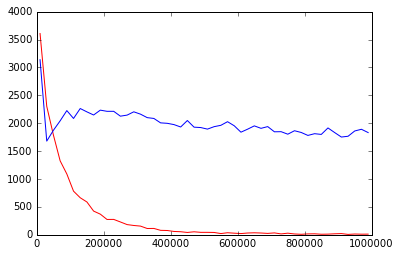

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure()
train = pd.read_csv('./JEME/K562/signal4Lasso.csv').set_index('id')
y1, edges = np.histogram(train['dis'][train['label']>0], bins=50, range=(0,1000000), normed=False)
y2, edges = np.histogram(train['dis'][train['label']<=0], bins=50, range=(0,1000000), normed=False)
centers = (edges[1:] + edges[:-1])*0.5
plt.plot(centers, y1, color='r')
plt.plot(centers, y2, color='b')

(114946, 423)
[       0.    20000.    40000.    60000.    80000.   100000.   120000.
   140000.   160000.   180000.   200000.   220000.   240000.   260000.
   280000.   300000.   320000.   340000.   360000.   380000.   400000.
   420000.   440000.   460000.   480000.   500000.   520000.   540000.
   560000.   580000.   600000.   620000.   640000.   660000.   680000.
   700000.   720000.   740000.   760000.   780000.   800000.   820000.
   840000.   860000.   880000.   900000.   920000.   940000.   960000.
   980000.  1000000.] [3780 2249 1748 1310 1062  778  647  588  421  354  271  281  213  187  167
  149  115  106   82   75   63   52   46   48   45   43   44   23   35   29
   21   31   37   34   24   37   12   30   13    9   16   19    9   14   17
   21    8   14   10   12] [3236 1700 1847 2061 2221 2097 2261 2200 2156 2227 2222 2195 2101 2165 2181
 2161 2103 2090 1990 1987 1960 1934 2054 1912 1912 1920 1921 1971 2006 1935
 1844 1903 1956 1895 1940 1862 1842 1777 1864 1842 1783 1806

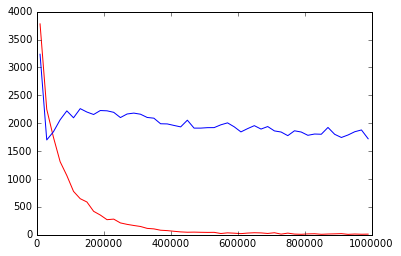

In [5]:
import matplotlib.pyplot as plt
train = pd.read_csv('targetfinder/K562/training.csv').set_index(['enhancer_name', 'promoter_name'])
print(train.shape)
all_dists = []
for w in train.loc[:,'window_name']:
    tokens = w.replace(':', '\t').replace('-',"\t").split()
    all_dists.append(int(tokens[2]) - int(tokens[1]))
train['dis'] = all_dists
y1, edges = np.histogram(train['dis'][train['label']>0], bins=50, range=(0,1000000), normed=False)
y2, edges = np.histogram(train['dis'][train['label']<=0], bins=50, range=(0,1000000), normed=False)
centers = (edges[1:] + edges[:-1])*0.5
plt.plot(centers, y1, color='r')
plt.plot(centers, y2, color='b')
print(edges, y1, y2)